We will now compare the models to test their performance compared to each other, the tests we will perform:
1. Accuracy as a function of number of epochs.
2. Accuracy as a number of data size.
3. Model performance of a data in which a sensor dropped out

First we will provide the helper functions to visualize and test the results, as well as data generation functions.

In [1]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import random_split
import torch.nn.functional as F
import copy
import scipy.ndimage as ndimage
import scipy.spatial.distance as dist_lib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# data generation

def generate_unified_data(num_samples=5000, grid_size=32, student_noise=0.001, teacher_noise=0.001, dropout_prob=0.3):
    dt = 0.01
    time_steps = 200
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]]) # 4 Corners


    X_clean = np.zeros((num_samples, 4, time_steps))
    y_locs = np.full((num_samples, 2, 2), -1.0)
    n_sources = np.zeros(num_samples, dtype=int)

    t_wave = np.arange(time_steps) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t_wave**2)) * np.exp(-(np.pi**2)*(f0**2)*(t_wave**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))


    for i in range(num_samples):
        # randomly generate 1 or 2 sources sample
        num_src = 1 if np.random.rand() > 0.5 else 2
        n_sources[i] = num_src

        current_signal = np.zeros((4, time_steps))

        for src_idx in range(num_src):
            src = np.random.rand(2) * [x_max, y_max]
            y_locs[i, src_idx] = src

            for s in range(4):
                dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
                arrival_time = dist / 300.0
                shift_steps = int(arrival_time / dt)
                amplitude = 1.0 / (dist + 1.0)

                if shift_steps < time_steps:
                    valid_len = time_steps - shift_steps
                    current_signal[s, shift_steps:] += wavelet_base[:valid_len] * amplitude

        X_clean[i] = current_signal

    # teacher data part
    teacher_noise_tensor = np.random.normal(0, teacher_noise, X_clean.shape)
    X_teacher = X_clean + teacher_noise_tensor

    # student data part
    student_noise_tensor = np.random.normal(0, student_noise, X_clean.shape)
    X_student = X_clean + student_noise_tensor

    for i in range(num_samples):
        if np.random.rand() < dropout_prob:
            dead_sensor_idx = np.random.randint(0, 4)
            X_student[i, dead_sensor_idx, :] = 0.0

    return (
        torch.tensor(X_student, dtype=torch.float32),
        torch.tensor(X_teacher, dtype=torch.float32),
        torch.tensor(y_locs, dtype=torch.float32),
        torch.tensor(n_sources, dtype=torch.long)
    )

In [3]:
# gaussian map creator function

def create_mixed_gaussian_map(source_locs, grid_size=32, sigma=3.0):

    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(source_locs)):
        # source 1
        cx1, cy1 = source_locs[i, 0]

        gauss1 = np.exp(-((xx - cx1)**2 + (yy - cy1)**2) / (2 * sigma**2))

        # source 2 if exists
        cx2, cy2 = source_locs[i, 1]

        # if there's only 1 source
        if cx2 == -1:
            combined = gauss1

        # if there are 2 sources
        else:
            gauss2 = np.exp(-((xx - cx2)**2 + (yy - cy2)**2) / (2 * sigma**2))
            combined = np.maximum(gauss1, gauss2)

        maps.append(combined)

    return np.array(maps)

In [95]:
# evaluating functions and plotting
def get_peak_location(heatmap):
    idx = np.unravel_index(np.argmax(heatmap), heatmap.shape)
    pixel_size = 100.0 / 32.0
    pred_y = idx[0] * pixel_size
    pred_x = idx[1] * pixel_size
    return np.array([pred_x, pred_y])

def calculate_accuracy(model, loader, device):
    model.eval()
    errors = []
    with torch.no_grad():
      for inputs, _, _, targets, _ in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).cpu().numpy()
        targets = targets.cpu().numpy()

        for i in range(len(inputs)):
          true_loc = get_peak_location(targets[i, 0])
          pred_loc = get_peak_location(outputs[i, 0])
          dist = np.linalg.norm(true_loc - pred_loc)
          errors.append(dist)
    return np.mean(errors)

In [5]:
def create_data_and_data_loaders(num_samples=5000, grid_size=32):
  X_s_raw, X_t_raw, Y_coords, n_sources = generate_unified_data(num_samples=num_samples, grid_size=grid_size)

  Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy(), grid_size=32, sigma=3.0)
  Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

  # split 80/10/10
  N = len(X_s_raw)
  indices = torch.randperm(N)

  n_train = int(0.8 * N)
  n_val = int(0.1 * N)
  n_test = N - n_train - n_val

  train_idx = indices[:n_train]
  val_idx   = indices[n_train:n_train+n_val]
  test_idx  = indices[n_train+n_val:]

  # split all data
  X_s_train, X_s_val, X_s_test = X_s_raw[train_idx], X_s_raw[val_idx], X_s_raw[test_idx]
  X_t_train, X_t_val, X_t_test = X_t_raw[train_idx], X_t_raw[val_idx], X_t_raw[test_idx]

  Y_c_train, Y_c_val, Y_c_test = Y_coords[train_idx], Y_coords[val_idx], Y_coords[test_idx]
  Y_h_train, Y_h_val, Y_h_test = Y_heatmaps[train_idx], Y_heatmaps[val_idx], Y_heatmaps[test_idx]
  n_src_train, n_src_val, n_src_test = n_sources[train_idx], n_sources[val_idx], n_sources[test_idx]

  # normalize data
  norm_s = torch.max(torch.abs(X_s_train))
  X_s_train = X_s_train / norm_s
  X_s_val   = X_s_val   / norm_s
  X_s_test  = X_s_test  / norm_s

  # normalize teacher data
  norm_t = torch.max(torch.abs(X_t_train))
  X_t_train = X_t_train / norm_t
  X_t_val   = X_t_val   / norm_t
  X_t_test  = X_t_test  / norm_t

  # creating dataloaders
  train_data = TensorDataset(X_s_train, X_t_train, Y_c_train, Y_h_train, n_src_train)
  val_data   = TensorDataset(X_s_val,   X_t_val,   Y_c_val,   Y_h_val,   n_src_val)
  test_data  = TensorDataset(X_s_test,  X_t_test,  Y_c_test,  Y_h_test,  n_src_test)

  train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
  val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False)
  test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)

  return train_loader, val_loader, test_loader

Next, we will define both models and the functions needed to train them

Starting with the CNN model

In [6]:
# model architecture
class WaveToMapNet(nn.Module):
    def __init__(self):
        super(WaveToMapNet, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, 7, stride=2, padding=3), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
        )

        # linear layer
        self.fc = nn.Linear(3200, 128 * 8 * 8)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

In [7]:
# helper layer to help the model avoid ghosting sources

class AddCoords(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        batch_size, _, length = input_tensor.size()
        coords = torch.linspace(-1, 1, length).to(input_tensor.device)
        coords = coords.view(1, 1, length).expand(batch_size, 1, length)

        return torch.cat([input_tensor, coords], dim=1)

In [8]:
class TeacherWaveToMapNet(nn.Module):
    def __init__(self):
        super(TeacherWaveToMapNet, self).__init__()
        self.coord_adder = AddCoords()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(5, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        # pooling
        self.global_pool = nn.AdaptiveAvgPool1d(25)

        # linear layer
        self.fc = nn.Linear(256 * 25, 128 * 16 * 16)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.coord_adder(x)
        x = self.encoder(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 16, 16)
        x = self.decoder(x)
        return x

In [9]:
def train_teacher(model, train_loader, val_loader, epochs=30, lr=0.001):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  for epoch in range(epochs):
      model.train()
      running_loss = 0.0

      for _, inputs, _, target_heatmaps, n_src in train_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, target_heatmaps)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      avg_loss = running_loss / len(train_loader)
      if (epoch+1) % 5 == 0:
          print(f"Teacher Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

  print("Training complete, Validating now")

  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for _, inputs, _, target_heatmaps, n_src in val_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
          val_loss += criterion(model(inputs), target_heatmaps).item()

          # save best params during training
          if val_loss < min_loss:
            best_params = copy.deepcopy(model.state_dict())
            min_loss = val_loss

  print(f"Teacher Validation Loss: {val_loss/len(val_loader):.6f}")
  model.load_state_dict(best_params) # load best params

In [10]:
# at the start we should rely more heavily on the teacher, and over time (epochs), the studnet would rely more on itself
# this helper function implements this logic

def get_alpha(epoch, epochs):
  starting_alpha = 0.8
  min_alpha = 0.1 # the lowest we will go
  epoch_decay_limit = int(0.8 * epochs)
  if epoch >= epochs:
    return min_alpha

  progress = epoch / epoch_decay_limit
  return starting_alpha - (progress * (starting_alpha - min_alpha))

In [55]:
def train_student(model, teacher_model, train_loader, val_loader, epochs=30, lr=0.001):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  teacher_model.eval()
  acc = []
  for epoch in range(epochs):
    alpha = get_alpha(epoch, epochs)
    model.train()
    running_loss = 0.0

    for inputs, teacher_inputs, _, target_heatmaps, n_src in train_loader:
      inputs, teacher_inputs, n_src, target_heatmaps = inputs.to(device), teacher_inputs.to(device), n_src.to(device), target_heatmaps.to(device)

      # add noise to student inputs
      noise = torch.randn_like(inputs) * 0.05
      student_inputs = inputs + noise

      # teacher evaluation
      with torch.no_grad():
        teacher_preds = teacher_model(teacher_inputs)

      student_preds = model(student_inputs)

      # calculate loss
      loss_truth = criterion(student_preds, target_heatmaps)
      loss_distill = criterion(student_preds, teacher_preds)

      loss = (1 - alpha) * loss_truth + alpha * loss_distill

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    curr_acc = calculate_accuracy(model, val_loader, device)
    acc.append(curr_acc)
    if (epoch+1) % 5 == 0:
        print(f"Distill Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

  print("Training complete, Validating now")
  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for _, inputs, _, target_heatmaps, n_src in val_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
          val_loss += criterion(model(inputs), target_heatmaps).item()

          # save best params during training
          if val_loss < min_loss:
            best_params = copy.deepcopy(model.state_dict())
            min_loss = val_loss

  print(f"Student Validation Loss: {val_loss/len(val_loader):.6f}")
  model.load_state_dict(best_params) # load best params
  return acc

Next, the FNO model

In [80]:
#TODO: add the FNO relevant code here, the current is only for initial testing
class LearnableBasisNet_Simple(nn.Module):
  def __init__(self, num_sensors=4, time_steps=200, grid_size=32):
    super(LearnableBasisNet_Simple, self).__init__()
    self.grid_size = grid_size
    self.time_steps = time_steps

    self.hidden_dim = 128
    self.learnable_transform = nn.Linear(time_steps, self.hidden_dim)

    input_dim = num_sensors * self.hidden_dim

    self.spectral_mixer = nn.Sequential(
        nn.Linear(input_dim, 2048),
        nn.ReLU(),
        nn.Linear(2048, 2048),
        nn.ReLU(),
        nn.Linear(2048, grid_size * grid_size)
    )

  def forward(self, x):
    batch_size = x.size(0)
    x_flat = x.view(-1, self.time_steps)

    x_freq = self.learnable_transform(x_flat)
    x_freq = torch.relu(x_freq)

    x_freq = x_freq.view(batch_size, -1)
    x_spatial = self.spectral_mixer(x_freq)

    output_map = x_spatial.view(batch_size, 1, self.grid_size, self.grid_size)
    return output_map

In [40]:
# TODO: update this training code to the latest
def train_fno(model, train_loader, val_loader, epochs=30, lr=0.001):
    opt_fno = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    acc = []
    for epoch in range(epochs):
      model.train()
      running_loss = 0.0

      for _, inputs, _, target_heatmaps, _ in train_loader:
        inputs, target_heatmaps = inputs.to(device), target_heatmaps.to(device)

        opt_fno.zero_grad()
        pred = model(inputs)
        loss = criterion(pred, target_heatmaps)
        loss.backward()
        opt_fno.step()

        running_loss += loss.item()

      acc.append(calculate_accuracy(model, val_loader, device))

      # Print loss every 5 epochs
      if (epoch + 1) % 5 == 0:
          print(f"FNO Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

    return acc

Now we will start with test #1 : Testing accuracy as a function of number of epochs. This simulates a case where you need to decide which model to use for this task when you have limited computational resources.

In [15]:
def plot_results(cnn_history, fno_history):
    epochs = len(cnn_history)
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(10, 6))

    # CNN part
    plt.plot(epochs_range, cnn_history, label='CNN Student', marker='o', linestyle='--', color='blue')

    # FNO part
    plt.plot(epochs_range, fno_history, label='FNO Student', marker='s', linestyle='-', color='orange')

    plt.title("Model Accuracy Comparison (Distillation Training)")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Mean Position Error (Meters) [Lower is Better]")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [17]:
train_loader, val_loader, test_loader = create_data_and_data_loaders(num_samples=5000, grid_size=32)

Choose the desired number of epochs to test, either way, the teacher will be trained for 30 epochs

In [76]:
total_epochs = 40

In [77]:
teacher = TeacherWaveToMapNet().to(device)
train_teacher(teacher, train_loader, val_loader, epochs=30)

Teacher Epoch 5/30 | Loss: 0.005358
Teacher Epoch 10/30 | Loss: 0.003912
Teacher Epoch 15/30 | Loss: 0.003474
Teacher Epoch 20/30 | Loss: 0.003130
Teacher Epoch 25/30 | Loss: 0.003063
Teacher Epoch 30/30 | Loss: 0.002881
Training complete, Validating now
Teacher Validation Loss: 0.003586


In [78]:
cnn = WaveToMapNet().to(device)
cnn_history = train_student(cnn, teacher, train_loader, val_loader, total_epochs)

Distill Epoch 5/40 | Loss: 0.020314
Distill Epoch 10/40 | Loss: 0.016248
Distill Epoch 15/40 | Loss: 0.015448
Distill Epoch 20/40 | Loss: 0.015437
Distill Epoch 25/40 | Loss: 0.015423
Distill Epoch 30/40 | Loss: 0.015517
Distill Epoch 35/40 | Loss: 0.015818
Distill Epoch 40/40 | Loss: 0.016091
Training complete, Validating now
Student Validation Loss: 0.008373


In [79]:
fno = LearnableBasisNet_Simple().to(device)
fno_history = train_fno(fno, train_loader, val_loader, total_epochs)

FNO Epoch 5/40 | Loss: 0.007214
FNO Epoch 10/40 | Loss: 0.004024
FNO Epoch 15/40 | Loss: 0.002912
FNO Epoch 20/40 | Loss: 0.002317
FNO Epoch 25/40 | Loss: 0.001893
FNO Epoch 30/40 | Loss: 0.001593
FNO Epoch 35/40 | Loss: 0.001370
FNO Epoch 40/40 | Loss: 0.001143


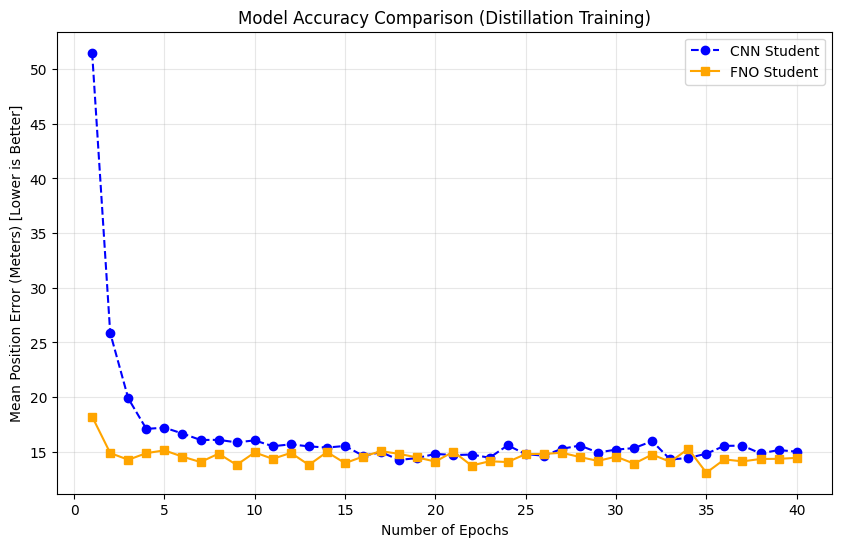

In [81]:
plot_results(cnn_history, fno_history)

In [62]:
def get_model_size_and_n_params(model, model_name):
  num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  param_size = 0
  for param in model.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
  size_all_mb = (param_size + buffer_size) / 1024 ** 2
  print(f"{model_name} size: {size_all_mb:.2f} MB")
  print(f"number of trainable params: {num_trainable_params}")
  return size_all_mb, num_trainable_params

In [75]:
teacher_size, teacher_params = get_model_size_and_n_params(teacher, "Teacher Model")
print("=" * 50)
CNN_size, CNN_params = get_model_size_and_n_params(cnn, "CNN Student Model")
print("=" * 50)
FNO_size, FNO_params = get_model_size_and_n_params(fno, "FNO Model")

Teacher Model size: 801.25 MB
number of trainable params: 210040897
CNN Student Model size: 100.98 MB
number of trainable params: 26469505
FNO Model size: 28.12 MB
number of trainable params: 7370880


In [68]:
print(f"ratio between CNN and FNO params is {CNN_params / FNO_params}")
print(f"ratio between CNN and FNO size is {CNN_size / FNO_size}")

ratio between CNN and FNO params is 3.5910915657289224
ratio between CNN and FNO size is 3.5912063417122515


As we can see, after about 3 epochs the FNO reaches its very low accuracy (the best is reached after ~35 epochs), and thats without even needing a teacher smart model and with 3.6 times less the cnn model number parameters and size

Moving on to the 2nd test: accuracy as a function of the size of the data.

For each amount of samples we will re-train all 3 models (teacher, student, fno), this will simulate a case in which you have different amounts of data to train your models with

In [96]:
def run_sample_efficiency_test(sample_sizes, val_size=500, epochs=20):

  max_train = max(sample_sizes)
  total_samples = max_train + val_size

  # generating data
  X_s_raw, X_t_raw, Y_coords, n_src_raw = generate_unified_data(num_samples=total_samples)
  Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy())
  Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

  val_slice = slice(max_train, total_samples)

  # defining validation data
  X_s_val_raw = X_s_raw[val_slice].clone()
  X_t_val_raw = X_t_raw[val_slice].clone()
  Y_c_val = Y_coords[val_slice]
  Y_h_val = Y_heatmaps[val_slice]
  n_src_val = n_src_raw[val_slice]

  results = {'sizes': [], 'cnn_acc': [], 'fno_acc': []}

  # for each size of data
  for size in sample_sizes:
    print(f"\n{'='*40}\nRunning Experiment: Train Size = {size}\n{'='*40}")

    # defining train data
    train_slice = slice(0, size)
    X_s_train = X_s_raw[train_slice].clone()
    X_t_train = X_t_raw[train_slice].clone()
    Y_c_train = Y_coords[train_slice]
    Y_h_train = Y_heatmaps[train_slice]
    n_src_train = n_src_raw[train_slice]

    # noramlize regarding the current training data being tested
    norm_s = torch.max(torch.abs(X_s_train))
    norm_t = torch.max(torch.abs(X_t_train))

    # normalize training data
    X_s_train /= norm_s
    X_t_train /= norm_t

    # normalize validation data
    X_s_val = X_s_val_raw.clone() / norm_s
    X_t_val = X_t_val_raw.clone() / norm_t

    # data datasets and loaders
    train_dataset = TensorDataset(X_s_train, X_t_train, Y_c_train, Y_h_train, n_src_train)
    val_dataset   = TensorDataset(X_s_val, X_t_val, Y_c_val, Y_h_val, n_src_val)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # models
    teacher = TeacherWaveToMapNet().to(device)
    cnn = WaveToMapNet().to(device)
    fno = LearnableBasisNet_Simple().to(device)

    print("Training Teacher")
    train_teacher(teacher, train_loader, val_loader, epochs=epochs)

    print("Training CNN Student")
    cnn_hist = train_student(cnn, teacher, train_loader, val_loader, epochs=epochs)

    print("Training FNO")
    fno_hist = train_fno(fno, train_loader, val_loader, epochs=epochs)

    results['sizes'].append(size)
    results['cnn_acc'].append(min(cnn_hist))
    results['fno_acc'].append(min(fno_hist))

  return results

In [87]:
def plot_sample_efficiency(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results['sizes'], results['cnn_acc'], marker='o', label='CNN Student')
    plt.plot(results['sizes'], results['fno_acc'], marker='s', label='FNO')

    plt.title("Sample Efficiency Comparison")
    plt.xlabel("Number of Training Samples")
    plt.ylabel("Mean Position Error (Meters)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Here you can modify the sample sized which will be tested

In [97]:
chosen_sample_sizes = [500, 1000, 2000, 3000, 5000]


Running Experiment: Train Size = 500
Training Teacher...
Teacher Epoch 5/15 | Loss: 0.016574
Teacher Epoch 10/15 | Loss: 0.009573
Teacher Epoch 15/15 | Loss: 0.007499
Training complete, Validating now
Teacher Validation Loss: 0.014331
Training CNN Student...
Distill Epoch 5/15 | Loss: 0.052914
Distill Epoch 10/15 | Loss: 0.035298
Distill Epoch 15/15 | Loss: 0.029267
Training complete, Validating now
Student Validation Loss: 0.027883
Training FNO Student...
FNO Epoch 5/15 | Loss: 0.025626
FNO Epoch 10/15 | Loss: 0.016355
FNO Epoch 15/15 | Loss: 0.011339

Running Experiment: Train Size = 1000
Training Teacher...
Teacher Epoch 5/15 | Loss: 0.012662
Teacher Epoch 10/15 | Loss: 0.008354
Teacher Epoch 15/15 | Loss: 0.005548
Training complete, Validating now
Teacher Validation Loss: 0.007206
Training CNN Student...
Distill Epoch 5/15 | Loss: 0.024425
Distill Epoch 10/15 | Loss: 0.018549
Distill Epoch 15/15 | Loss: 0.017855
Training complete, Validating now
Student Validation Loss: 0.013428
T

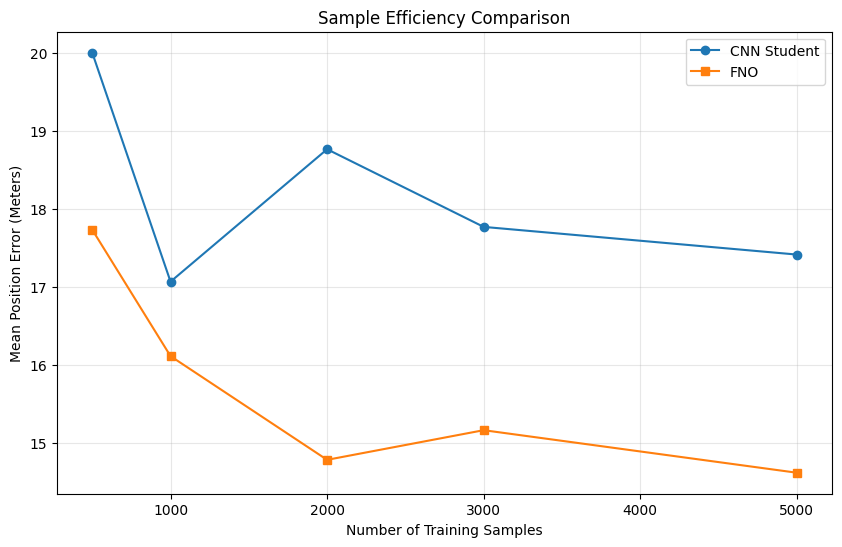

In [91]:
results = run_sample_efficiency_test(sample_sizes = chosen_sample_sizes, epochs=15)
plot_sample_efficiency(results)

Again we see that for every number of data size you might have, its better to use the FNO.

In [109]:
# TODO: check on large amounts of data like 10k, 25k, 50k

Now we will check what happens when you train your models on clean data, but then in the "money-time" one of the sensors is malfunctioning, meaning it provides no data at all or very noisy data

In [98]:
def create_malfunction_loader(original_loader, target_sensor_idx=0, high_noise_level=0.5, device='cuda'):
    malfunction_data = []

    for inputs, t_in, coords, hmaps, n_src in original_loader:

        # create a copy of the inputs to have a clean and corrupt one
        corrupt_inputs = inputs.clone()

        batch_size = inputs.shape[0]

        # random mask for the malfunctioning sensor
        is_dead_mask = torch.rand(batch_size) > 0.5

        for i in range(batch_size):
            if is_dead_mask[i]:
                # dead sensor case
                corrupt_inputs[i, target_sensor_idx, :] = 0.0
            else:
                # high noise case
                noise = torch.randn_like(corrupt_inputs[i, target_sensor_idx, :]) * high_noise_level
                corrupt_inputs[i, target_sensor_idx, :] += noise

        malfunction_data.append((corrupt_inputs, t_in, coords, hmaps, n_src))

    return malfunction_data

In [107]:
def plot_robustness_comparison(c_clean, c_broken, f_clean, f_broken):
  labels = ['Standard Test Set', 'Malfunction Test Set']
  cnn_scores = [c_clean, c_broken]
  fno_scores = [f_clean, f_broken]

  x = np.arange(len(labels))
  width = 0.35

  plt.figure(figsize=(8, 6))
  plt.bar(x - width/2, cnn_scores, width, label='CNN Student', color='royalblue')
  plt.bar(x + width/2, fno_scores, width, label='FNO Model', color='darkorange')

  plt.ylabel('Mean Position Error (Meters)')
  plt.title('Robustness to Sensor Malfunction (Dead/Noisy)')
  plt.xticks(x, labels)
  plt.legend()
  plt.grid(axis='y', alpha=0.3)
  plt.show()

In [113]:
def run_sensor_malfunction_experiment(train_size=5000, val_size=500, test_size=1000, epochs=20, sensor_idx=0):
  # helper function to create data loaders
  def create_loader(s_slice, shuffle):
    # Normalize
    x_s = X_s_raw[s_slice].clone() / norm_s
    x_t = X_t_raw[s_slice].clone() / norm_t
    data = TensorDataset(x_s, x_t, Y_coords[s_slice], Y_heatmaps[s_slice], n_src_raw[s_slice])
    return DataLoader(data, batch_size=64, shuffle=shuffle)


  print(f"\n{'='*60}\nRunning Sensor Malfunction Robustness Test\n{'='*60}")

  # generate data
  total_samples = train_size + val_size + test_size
  X_s_raw, X_t_raw, Y_coords, n_src_raw = generate_unified_data(num_samples=total_samples, dropout_prob=0)
  Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy())
  Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

  # split into train, val, test
  train_sl = slice(0, train_size)
  val_sl   = slice(train_size, train_size + val_size)
  test_sl  = slice(train_size + val_size, total_samples)

  # normaliztion factor
  norm_s = torch.max(torch.abs(X_s_raw[train_sl]))
  norm_t = torch.max(torch.abs(X_t_raw[train_sl]))

  # creating loaders
  train_loader = create_loader(train_sl, shuffle=True)
  val_loader   = create_loader(val_sl, shuffle=False)
  test_loader  = create_loader(test_sl, shuffle=False)

  # train models on clean data
  print("Training models on clean data")
  teacher = TeacherWaveToMapNet().to(device)
  cnn = WaveToMapNet().to(device)
  fno = LearnableBasisNet_Simple().to(device)

  train_teacher(teacher, train_loader, val_loader, epochs=epochs)
  print("Teacher Trained")

  train_student(cnn, teacher, train_loader, val_loader, epochs=epochs)
  print("CNN Student Trained")

  train_fno(fno, train_loader, val_loader, epochs=epochs)
  print(" FNO Trained")

  # create corrupted data
  print(f"\n Generating Malfunction Test Set (Sensor {sensor_idx} -> Dead/Noisy)...")
  malfunction_loader = create_malfunction_loader(test_loader, target_sensor_idx=sensor_idx, high_noise_level=0.5)

  print("\n Evaluating...")

  # check accuracy on the clean dataset
  acc_cnn_clean = calculate_accuracy(cnn, test_loader, device)
  acc_fno_clean = calculate_accuracy(fno, test_loader, device)

  # check accuracy on the corrupted dataset
  acc_cnn_broken = calculate_accuracy(cnn, malfunction_loader, device)
  acc_fno_broken = calculate_accuracy(fno, malfunction_loader, device)

  # plot
  print(f"\nResults Summary:")
  print(f"CNN | Clean Error: {acc_cnn_clean:.2f}m | Broken Sensor Error: {acc_cnn_broken:.2f}m")
  print(f"FNO | Clean Error: {acc_fno_clean:.2f}m | Broken Sensor Error: {acc_fno_broken:.2f}m")

  plot_robustness_comparison(acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken)


Choose which sensor to fail and the number of epochs the models will train

In [104]:
chosen_epochs = 20
sensor_index = 1 # should be one of 0,1,2,3


Running Sensor Malfunction Robustness Test
Training models on clean data
Teacher Epoch 5/20 | Loss: 0.004988
Teacher Epoch 10/20 | Loss: 0.003902
Teacher Epoch 15/20 | Loss: 0.003609
Teacher Epoch 20/20 | Loss: 0.003425
Training complete, Validating now
Teacher Validation Loss: 0.004018
Teacher Trained
Distill Epoch 5/20 | Loss: 0.015961
Distill Epoch 10/20 | Loss: 0.015747
Distill Epoch 15/20 | Loss: 0.016014
Distill Epoch 20/20 | Loss: 0.016554
Training complete, Validating now
Student Validation Loss: 0.009889
CNN Student Trained
FNO Epoch 5/20 | Loss: 0.006812
FNO Epoch 10/20 | Loss: 0.003922
FNO Epoch 15/20 | Loss: 0.002864
FNO Epoch 20/20 | Loss: 0.002389
 FNO Trained

 Generating Malfunction Test Set (Sensor 1 -> Dead/Noisy)...

 Evaluating...

Results Summary:
CNN | Clean Error: 16.87m | Broken Sensor Error: 30.08m
FNO | Clean Error: 14.97m | Broken Sensor Error: 31.75m


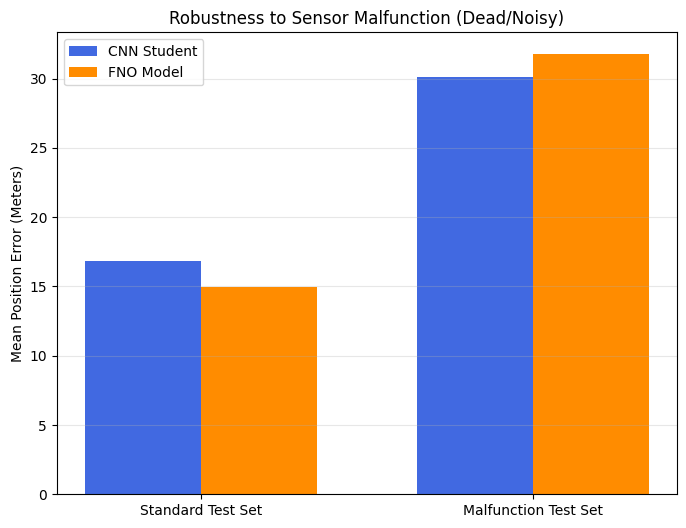

In [114]:
run_sensor_malfunction_experiment(epochs=chosen_epochs, sensor_idx=sensor_index)

Finally the CNN is better at something, it beats the FNO on noisy data regarding mean accuracy by ~1.7 meters when one of the sensors is malfunctioning